# Acha buracos em sementes

In [3]:
import cv2
import imutils
import numpy as np
import matplotlib.pyplot as plt
from skimage import measure
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
from shapely.geometry import Polygon

def para_poligonos(input_image):
	return measure.find_contours(input_image, 125)

def remove_fundo(input_image):
	two_dimensional_image = input_image.reshape((-1, 3))
	two_dimensional_image = np.float32(two_dimensional_image)

	criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 1.0)
	clusters = 2
	flags = cv2.KMEANS_PP_CENTERS

	result_image_compactness, result_image_labels, result_image_centers = cv2.kmeans(two_dimensional_image, clusters, None, criteria, 10, flags)

	result_image_centers = np.uint8(result_image_centers)
	result_image = result_image_centers[result_image_labels.flatten()]
	result_image = result_image.reshape((input_image.shape))

	thresholded_blue_component, thresholded_green_component, thresholded_red_component = cv2.split(result_image)

	used_threshold, thresholded_bgr_image = cv2.threshold(result_image, 130, 255, cv2.THRESH_BINARY)
	thresholded_blue_component, thresholded_green_component, thresholded_red_component = cv2.split(thresholded_bgr_image)

	thresholded_red_component = cv2.medianBlur(thresholded_red_component, 5)

	return (thresholded_blue_component, thresholded_green_component, thresholded_red_component)

def alinhar(imagem_original):
	"""Funcao que recebe uma imagem de malha com sementes
	e retorna uma imagem com a malha alinhada.
	"""
	
	# Tamanho da imagem
	[x, y, z] = np.shape(imagem_original)

	# Faz a segmentacao com thresholding
	(T, imagem_thresh) = cv2.threshold(imagem_original, 115, 255, cv2.THRESH_BINARY)

	# Deixa a imagem em escala de cinza
	imagem_cinza = cv2.cvtColor(imagem_thresh, cv2.COLOR_BGR2GRAY)

	# Prepara para alinhamento
	# Ponto de busca da borda da malha situado no hemisferio norte da imagem
	ponto_busca1 = [int(x*(1/3)), int(y*(1/10))]

	# Ponto situado no hemisferio sul da imagem
	ponto_busca2 = [int(x*(2/3)), int(y*(1/10))]

	# Move o ponto de busca 1 a direita ate encontrar a borda da malha
	while True:
		if (imagem_cinza[ponto_busca1[0], ponto_busca1[1]] == 0):
			# Sai do loop com coordenada x na borda da malha
			break
		# Caso pixel nao possua o valor desejado
		ponto_busca1[1] = ponto_busca1[1] + 1

	# Move o ponto de busca 2 a direita ate encontrar a borda da malha
	while True:
		if (imagem_cinza[ponto_busca2[0], ponto_busca2[1]] == 0 ):
			# Sai do loop com coordenada x na borda da malha
			break

	    # Caso pixel nao possua o valor desejado
		ponto_busca2[1] = ponto_busca2[1] + 1


	
	# Calculo do angulo de rotacao utilizando trigonometria
	L1 = ponto_busca2[0] - ponto_busca1[0] # Cateto adjacente
	L2 = ponto_busca2[1] - ponto_busca1[1] # Cateto oposto
	angulo = np.arctan(L2/L1)
	angulo = np.rad2deg(angulo)

	# Rotaciona a imagem
	imagem_rot = imutils.rotate(imagem_original, -angulo)
	
	return imagem_rot


def cortar_malha(imagem_original):
	"""Funcao que recebe uma imagem de malha com sementes
	e retorna um vetor com 50 sementes individuais.
	"""

	# Alinha a imagem
	imagem_alinhada = alinhar(imagem_original)

	# Tamanho da imagem
	[x, y, z] = np.shape(imagem_alinhada)

	# Faz a segmentacao com thresholding
	(T, imagem_thresh) = cv2.threshold(imagem_alinhada, 115, 255, cv2.THRESH_BINARY)

	# Deixa a imagem em escala de cinza
	imagem_cinza = cv2.cvtColor(imagem_thresh, cv2.COLOR_BGR2GRAY)

	# Prepara para corte
	# Ponto de busca da borda da malha situado no lado esquerdo da imagem
	ponto_medio1 = [int(x*(1/2)), int(y*(1/10))]

	# Ponto situado no lado direito da imagem
	ponto_medio2 = [int(x*(1/2)), int(y*(9.5/10))]

	# Ponto situado na parte inferior da imagem
	ponto_medio3 = [int(x*0.96866), int(y*(1/2))]

	# Ponto situado na parte superior da imagem
	ponto_medio4 = [int(x*0.03134), int(y*(1/2))]

	# Move o ponto de busca 1 a direita ate encontrar a borda da malha
	while True:
		if (imagem_cinza[ponto_medio1[0], ponto_medio1[1]] == 0):
			# Sai do loop com coordenada y na borda da malha
			break

		# Caso pixel nao possua o valor desejado
		ponto_medio1[1] = ponto_medio1[1] + 1
		
	# Move o ponto de busca 2 a esquerda ate encontrar a borda da malha
	while True:
		if (imagem_cinza[ponto_medio2[0], ponto_medio2[1]] == 0):
			# Sai do loop com coordenada y na borda da malha
			break

		# Caso pixel nao possua o valor desejado
		ponto_medio2[1] = ponto_medio2[1] - 1

	# Move o ponto de busca 3 para cima ate encontrar a borda da malha
	while True:
		if (imagem_cinza[ponto_medio3[0], ponto_medio3[1]] == 0 ):
			# Sai do loop com coordenada x na borda da malha
			break

		# Caso pixel nao possua o valor desejado
		ponto_medio3[0] = ponto_medio3[0] - 1
		
	# Move o ponto de busca 4 para baixo ate encontrar a borda da malha
	while True:
		if (imagem_cinza[ponto_medio4[0], ponto_medio4[1]] == 0 ):
			# Sai do loop com coordenada x na borda da malha
			break

		# Caso pixel nao possua o valor desejado
		ponto_medio4[0] = ponto_medio4[0] + 1
		
	# Coordenadas do vertice inferior esquerdo da malha
	coords1 = [ponto_medio3[0], ponto_medio1[1]]
	coords2 = [ponto_medio3[0], ponto_medio2[1]]
	y_inicial = coords1[1]

	# Medidas aproximadas dos lados das secoes
	comp_malha = coords2[1] - coords1[1]		# Comprimento da malha
	lado_comp = int(comp_malha/5)			# Comprimento da secao
	alt_malha = ponto_medio3[0] - ponto_medio4[0]	# Altura da malha
	lado_alt = int(alt_malha/10)			# Altura da secao

	# Define vetor onde sera armazenada cada semente
	semente = []

	# Popula o vetor com as sementes adequadas, sendo semente[0] a semente 1
	for i in range(10):
		for j in range(5):
			semente.append(imagem_alinhada[(coords1[0] - lado_alt):coords1[0], coords1[1]:(coords1[1] + lado_comp)])
			coords1[1] = coords1[1] + lado_comp
		# Prepara para obter as imagens das sementes da linha acima
		coords1[1] = y_inicial
		coords1[0] = coords1[0] - lado_alt
		
	return semente

(0.0, 256.0)

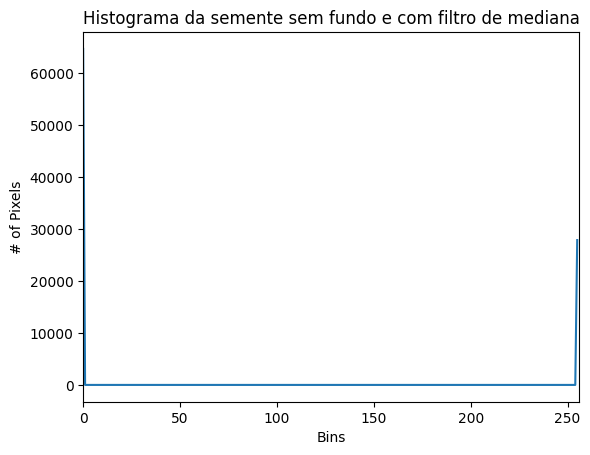

In [21]:
target = './LOTE 1 R1 INTERNA.jpeg'

input_image = cv2.imread(target)

scale_percent = 25
width = int(input_image.shape[1] * scale_percent / 100)
height = int(input_image.shape[0] * scale_percent / 100)
dim = (width, height)

# plt.imshow(cv2.resize(input_image, dim, interpolation = cv2.INTER_AREA))

seeds = cortar_malha(input_image)


seed = seeds[0]
(thresholded_blue_component, thresholded_green_component, thresholded_red_component) = remove_fundo(seed
)


hist = cv2.calcHist([thresholded_red_component],[0],None,[256],[0,256])
plt.figure()
plt.title("Histograma da semente sem fundo e com filtro de mediana")
plt.xlabel("Bins")
plt.ylabel("# of Pixels")
plt.plot(hist)
plt.xlim([0, 256])


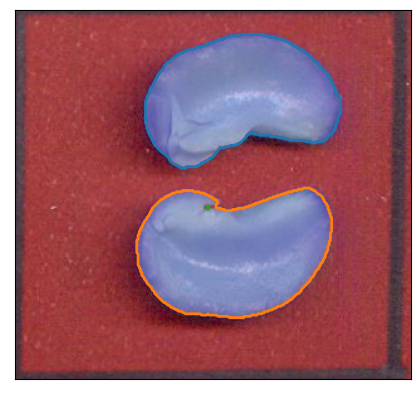

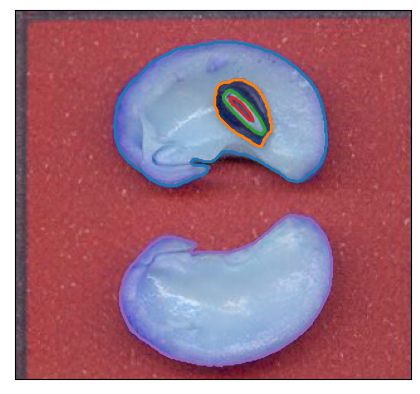

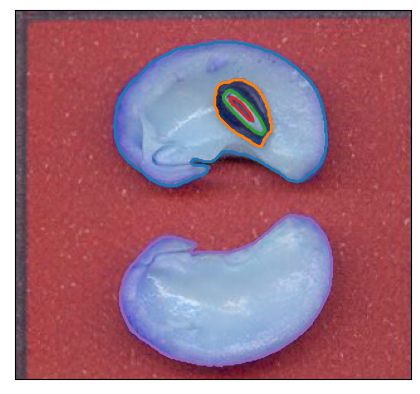

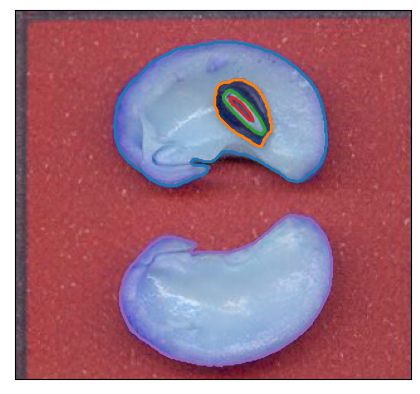

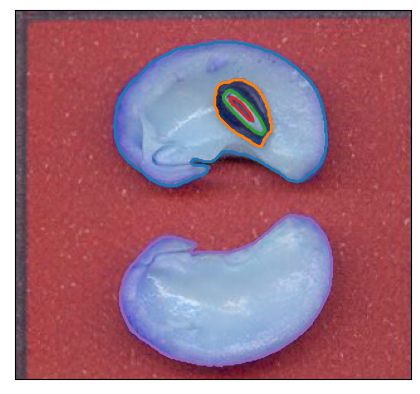

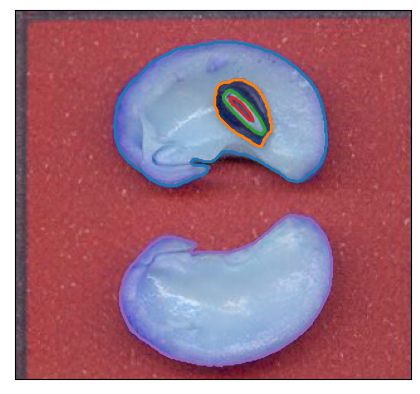

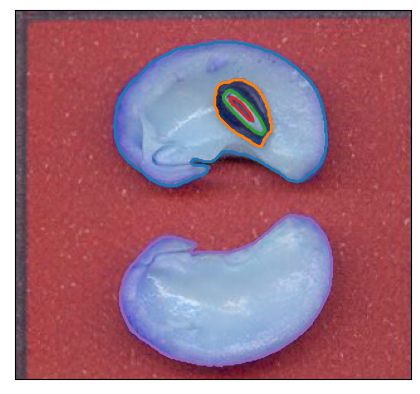

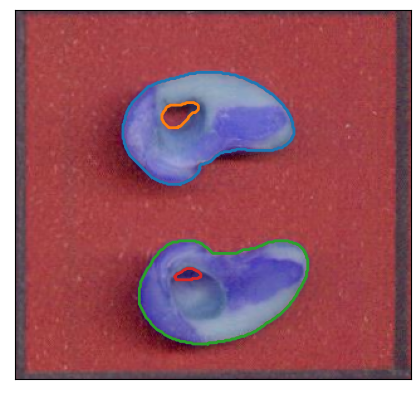

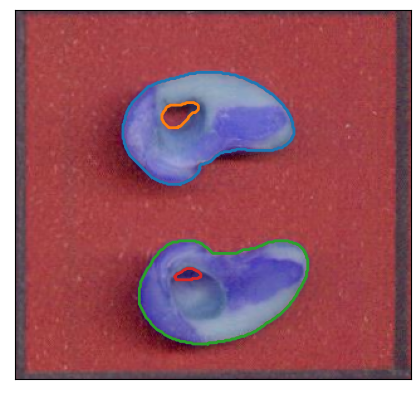

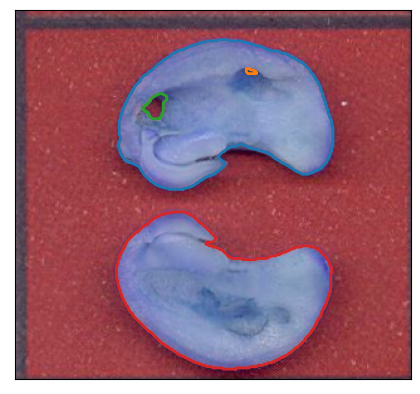

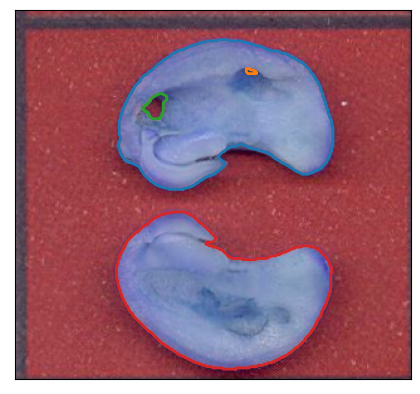

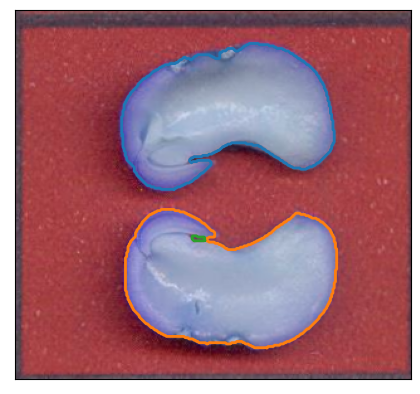

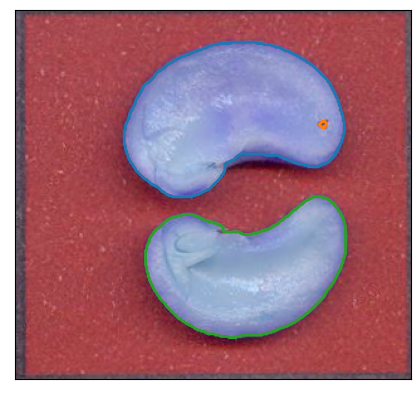

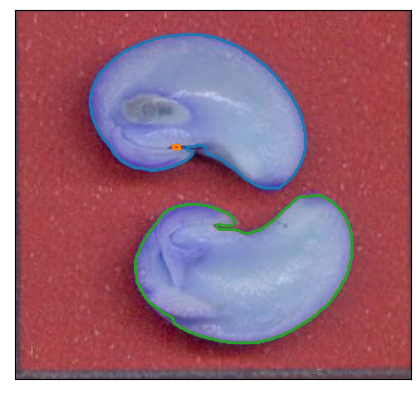

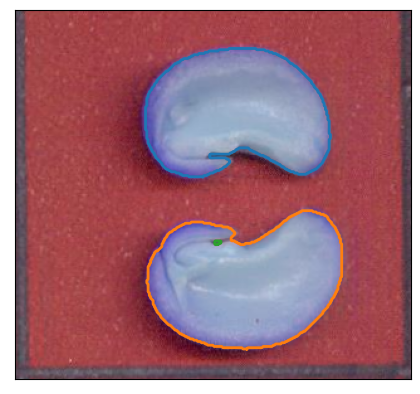

In [22]:
i = 1
for seed in seeds:
    (thresholded_blue_component, thresholded_green_component, thresholded_red_component) = remove_fundo(seed)
    # fig, (ax1, ax2) = plt.subplots(1, 2)
    # fig.suptitle(f'Semente {i}')
    # ax1.imshow(seed)
    # ax2.imshow(thresholded_red_component)

    # plt.show()

    contours = para_poligonos(thresholded_red_component)

    for a in contours:
        for b in contours:
            if (a.tolist() == b.tolist()):
                continue
            
            if(len(a) < 3 or len(b) < 3):
                continue

            A = Polygon(a)
            B = Polygon(b)

            if(A.contains(B)):
                # TODO: checar se já adicionou aquele polígono
                # print("Achou um buraco!!!!!")


                fig, ax = plt.subplots()
                ax.imshow(seed)

                for contour in contours:
                    ax.plot(contour[:, 1], contour[:, 0], linewidth=2)

                ax.axis('image')
                ax.set_xticks([])
                ax.set_yticks([])
                plt.show()


    # plt.imshow(seed)
    # plt.show()

    # plt.imshow(thresholded_red_component)
    # plt.show()


    # if i == 2:
    #     break

    i += 1

plt.close()